In [37]:
import wandb

wandb.init()

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import torch
from torchvision import transforms
import torchstain
from PIL import Image
import random

In [2]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")


(4981, 256, 256, 3)


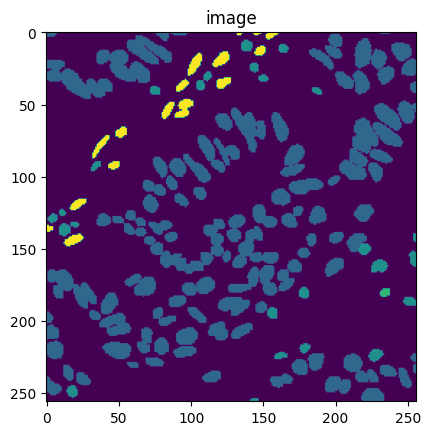

array([0, 2, 3, 4, 6], dtype=uint16)

In [7]:
print(images.shape)
plt.imshow(labels[4320][..., 1])
plt.title("image")
plt.show()
np.unique(labels[4320][..., 1])

(256, 256, 3) (256, 256) uint8 uint8


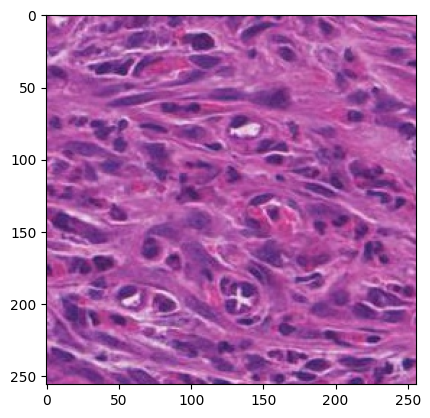

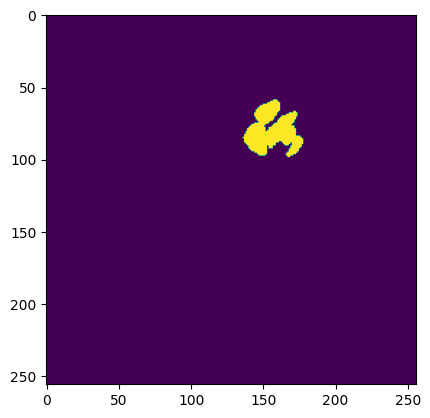

In [8]:
img = images[4000]
mask = labels[0][..., 0].astype(np.uint8)

print(img.shape, mask.shape, img.dtype, mask.dtype)

# mask[mask!=0] = 255
# mask = cv2.merge((mask, mask, mask))

# res = cv2.bitwise_or(img, img, mask=mask)
plt.imshow(img)
plt.show()
# plt.imshow(mask)
# plt.show()
# plt.imshow(res)
# plt.show()

new = np.zeros((256, 256))

contours, hierarchy= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
for i, c in enumerate(sorted_contours):
    cv2.drawContours(new, [c], -1, (255), cv2.FILLED)

    plt.imshow(new)
    plt.show()
    break

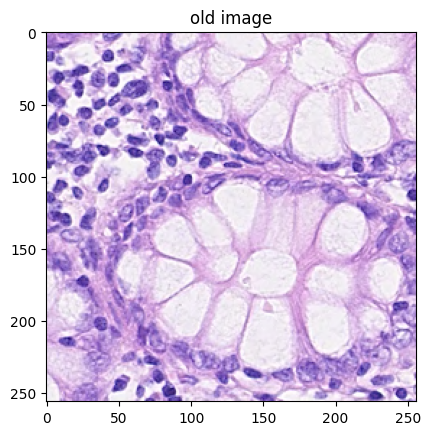

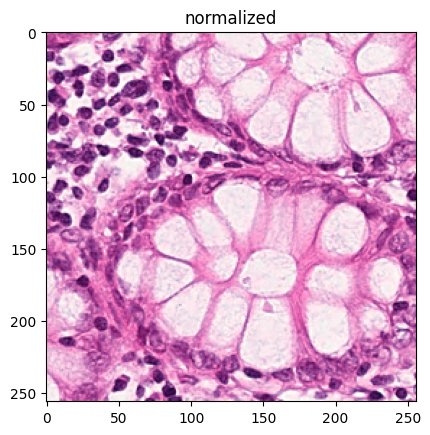

In [9]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
from torchvision import transforms
import torchstain

i = 10
target = images[4000]

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
torch_normalizer.fit(T(target))

to_transform = images[i]
t_to_transform = T(to_transform)
norm, _, _ = torch_normalizer.normalize(I=t_to_transform, stains=True)

plt.imshow(images[i])
plt.title("old image")
plt.show()

plt.imshow(norm)
plt.title("normalized")
plt.show()

In [20]:
i = 10
target = images[0]

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
torch_normalizer.fit(T(target))

for j in range(10):
    i = random.randint(1, 4980)

    to_transform = images[i]
    t_to_transform = T(to_transform)
    norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)
    
    # print(images[i].dtype)
    # print(norm.detach().numpy().astype(np.uint8).dtype)
    # break
    im = Image.fromarray(images[i])
    im.save(f"vis/old-{j}.png")
    
    im = Image.fromarray(norm.detach().numpy().astype(np.uint8))
    im.save(f"vis/norm-{j}.png")

# print(np.size(np.unique(labels[i][...,1])))

# plt.imshow(images[i])
# plt.title("old image")
# plt.show()

# plt.imshow(labels[i][...,1])
# plt.title("old image")
# plt.show()

# plt.imshow(norm)
# plt.title("normalized")
# plt.show()

# im = Image.fromarray(images[0])
# im.save("vis/target.png")

# plt.imshow(images[100])
# plt.title("target")
# plt.show()

_LinAlgError: linalg.eigh: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 2).

[[ 71.33333333  71.33333333  74.66666667 ... 126.33333333 128.
  130.        ]
 [ 69.33333333  66.66666667  69.         ... 111.66666667 122.
  124.33333333]
 [ 77.33333333  71.33333333  73.33333333 ...  96.33333333 111.66666667
  124.66666667]
 ...
 [199.33333333 188.66666667 177.33333333 ... 141.66666667 156.
  155.33333333]
 [215.66666667 207.66666667 204.         ... 144.33333333 149.66666667
  148.66666667]
 [224.         220.66666667 218.33333333 ... 145.66666667 151.33333333
  158.66666667]]
[[[ 82  22 110]
  [ 86  17 111]
  [ 90  20 114]
  ...
  [159  56 164]
  [165  56 163]
  [173  59 158]]

 [[ 78  21 109]
  [ 77  16 107]
  [ 80  17 110]
  ...
  [139  42 154]
  [154  51 161]
  [165  55 153]]

 [[ 92  24 116]
  [ 87  17 110]
  [ 88  18 114]
  ...
  [122  30 137]
  [143  43 149]
  [164  54 156]]

 ...

 [[237 160 201]
  [241 131 194]
  [237 109 186]
  ...
  [165  71 189]
  [181  88 199]
  [183  93 190]]

 [[235 193 219]
  [242 178 203]
  [245 170 197]
  ...
  [169  75 189]
  [1

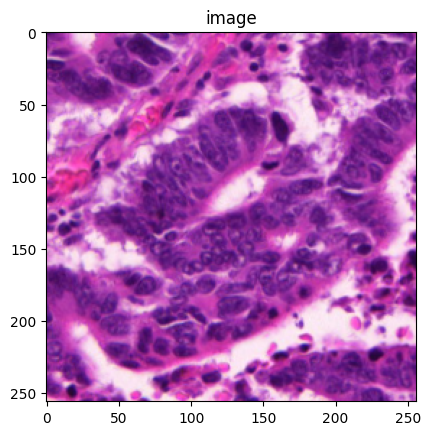

IndexError: boolean index did not match indexed array along dimension 1; dimension is 255 but corresponding boolean dimension is 3

In [41]:
img = images[4320]

print(np.mean(img, axis=2))
print(img)

plt.imshow(img)
plt.title("image")
plt.show()

translation_matrix = np.float32([ [1,0,4], [0,1,4] ])
img_translation = cv2.warpAffine(img, translation_matrix, (255, 255))
mask = np.zeros(img_translation.shape[0:2], dtype=np.uint8)

mask[0 == sum(img_translation)] = 255

print(img_translation.shape)

plt.imshow(img_translation)
plt.title("image")
plt.show()

img_translation = cv2.inpaint(img_translation, mask, 3, cv2.INPAINT_TELEA)

plt.imshow(img_translation)
plt.title("image")
plt.show()

img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(img)
plt.title("image")
plt.show()

img = cv2.flip(img, 0)

plt.imshow(img)
plt.title("image")
plt.show()

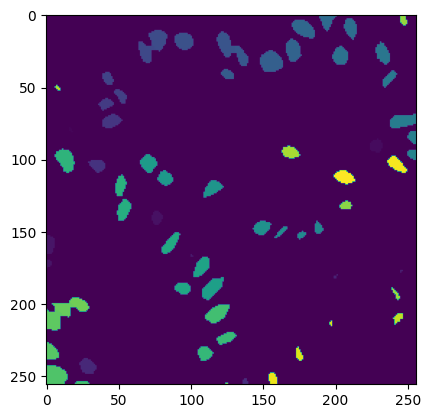

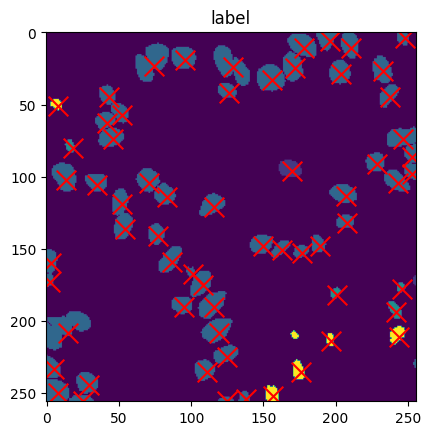

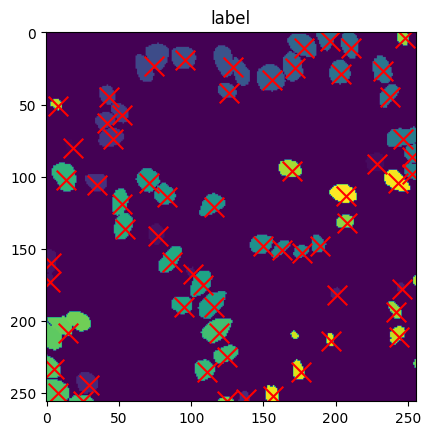

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


In [5]:
i = 321
individuals = np.uint8(labels[i][...,0])
label = np.uint8(labels[i][...,1])
image = images[i]
size = 32

img = individuals.copy()

image_size = individuals.shape[0]

kernel = np.ones((4, 4), np.uint8)
img_erosion = cv2.erode(img, kernel, iterations=1)

plt.imshow(img_erosion)
plt.show()

# plt.imshow(img)
# plt.show()

contours, hierarchy= cv2.findContours(img_erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

# plt.imshow(label)
# plt.imshow(edges, cmap='jet', alpha=0.5)
# plt.title("label")
# plt.show()

# print(sorted_contours[0][0][0][1])
# fig, ax = plt.subplots()
# plt.imshow(label)
# for c in sorted_contours:
#     x,y,w,h= cv2.boundingRect(c)
#     # print(x, y, w, h)
#     # Create a Rectangle patch
#     rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

#     # Add the patch to the Axes
#     ax.add_patch(rect)
    
# plt.title("label")
# plt.show()

points = []
classes = []

for i, c in enumerate(sorted_contours):
    x,y,w,h= cv2.boundingRect(c)
    slice_h_1 = y-(size-h)//2
    slice_h_2 = y-(size-h)//2 + size
    slice_w_1 = x-(size-w)//2
    slice_w_2 = x-(size-w)//2 + size
    
    # print(slice_w_1, slice_w_2, slice_h_1, slice_h_2)
    middle_x = slice_w_1+(slice_w_2-slice_w_1)//2
    middle_y = slice_h_1+(slice_h_2-slice_h_1)//2
    # print(middle_x, middle_y)
    if middle_x > 255:
        middle_x = 255
    if middle_x < 0:
        middle_x = 0
    if middle_y > 255:
        middle_y = 255
    if middle_y < 0:
        middle_y = 0
    
    if(slice_h_1 < 0): 
        slice_h_1, slice_h_2 = (0, size)
    if(slice_w_1 < 0): 
        slice_w_1, slice_w_2 = (0, size)
    if(slice_h_2 > image_size): 
        slice_h_1, slice_h_2 = (image_size-size, image_size)
    if(slice_w_2 > image_size): 
        slice_w_1, slice_w_2 = (image_size-size, image_size)
    
    img = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
    current_class = label[middle_x, middle_y]
    classes.append(current_class)
    
    points.append(np.array([middle_x, middle_y]))
    
    # plt.imshow(img)
    # plt.title("image")
    # plt.show()
    # print(current_class)
points = np.array(points)
plt.imshow(label)
plt.scatter(points[:, 0], points[:, 1], marker="x", color="red", s=200)
# plt.imshow(edges, cmap='jet', alpha=0.5)
plt.title("label")
plt.show()

plt.imshow(individuals)
plt.scatter(points[:, 0], points[:, 1], marker="x", color="red", s=200)
plt.title("label")
plt.show()

print(classes)
    

In [7]:
np.unique(individuals)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69], dtype=uint8)

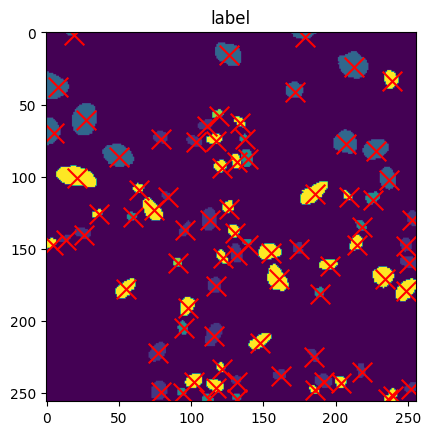

[2, 5, 2, 3, 2, 1, 3, 3, 3, 3, 5, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6]


In [18]:
i = 345
individuals = np.uint8(labels[i][...,0])
label = np.uint8(labels[i][...,1])
image = images[i]
size = 32

img = individuals.copy()

image_size = individuals.shape[0]

points = []
classes = []

for ind in np.unique(individuals):
    if ind == 0:
        continue
    my_img = individuals.copy()
    my_img[my_img != ind] = 0
    contours, hierarchy= cv2.findContours(my_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

    for i, c in enumerate(sorted_contours):
        x,y,w,h= cv2.boundingRect(c)
        slice_h_1 = y-(size-h)//2
        slice_h_2 = y-(size-h)//2 + size
        slice_w_1 = x-(size-w)//2
        slice_w_2 = x-(size-w)//2 + size
        
        cell = label[y:y+h, x:x+w]
        current_class = np.max(cell)
        

        # print(slice_w_1, slice_w_2, slice_h_1, slice_h_2)
        middle_x = slice_w_1+(slice_w_2-slice_w_1)//2
        middle_y = slice_h_1+(slice_h_2-slice_h_1)//2
        # print(middle_x, middle_y)
        if middle_x > 255:
            middle_x = 255
        if middle_x < 0:
            middle_x = 0
        if middle_y > 255:
            middle_y = 255
        if middle_y < 0:
            middle_y = 0

        if(slice_h_1 < 0): 
            slice_h_1, slice_h_2 = (0, size)
        if(slice_w_1 < 0): 
            slice_w_1, slice_w_2 = (0, size)
        if(slice_h_2 > image_size): 
            slice_h_1, slice_h_2 = (image_size-size, image_size)
        if(slice_w_2 > image_size): 
            slice_w_1, slice_w_2 = (image_size-size, image_size)

        img = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
        classes.append(current_class)

        points.append(np.array([middle_x, middle_y]))

points = np.array(points)
plt.imshow(label)
plt.scatter(points[:, 0], points[:, 1], marker="x", color="red", s=200)
# plt.imshow(edges, cmap='jet', alpha=0.5)
plt.title("label")
plt.show()

print(classes)
    

In [1]:
arr_labels = []
arr_images = []
classes = []
print(images.shape[0])
for n in range(images.shape[0]):
    # n = 40
    size = 32

    individuals = np.uint8(labels[n][...,0])
    label = np.uint8(labels[n][...,1])
    image = images[n]

    image_size = individuals.shape[0]

    edges= cv2.Canny(individuals, 100,200)
    contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
    
    for (i,c) in enumerate(sorted_contours):
        x,y,w,h= cv2.boundingRect(c)
        slice_h_1 = y-(size-h)//2
        slice_h_2 = y-(size-h)//2 + size
        # slice_h_2 = y+h+(size-h)//2
        slice_w_1 = x-(size-w)//2
        # slice_w_2 = x+w+(size-w)//2
        slice_w_2 = x-(size-w)//2 + size

        if(slice_h_1 < 0): 
            slice_h_1, slice_h_2 = (0, size)
        if(slice_w_1 < 0): 
            slice_w_1, slice_w_2 = (0, size)
        if(slice_h_2 > image_size): 
            slice_h_1, slice_h_2 = (image_size-size, image_size)
        if(slice_w_2 > image_size): 
            slice_w_1, slice_w_2 = (image_size-size, image_size)


        cropped_label = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
        cropped_image = image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]

        arr_labels.append(cropped_label)
        arr_images.append(cropped_image)
        current_class = label[slice_h_1 + size//2][slice_w_1 + size//2]
        classes.append(current_class)
    if n % 1000 == 0:
        print(n)

NameError: name 'images' is not defined

In [251]:
np.array(arr_labels).shape

KeyboardInterrupt: 

In [ ]:
arr_images = np.array(arr_images)
arr_labels = np.array(arr_labels)

In [ ]:
print(arr_images.shape)
print(arr_labels.shape)

In [ ]:
x = 124
print(f'class: {classes[x]}')
plt.imshow(arr_labels[x])
plt.show()
plt.imshow(arr_images[x])
plt.show()


In [ ]:
plt.imshow(image)

In [ ]:
arr = []
for i in range(5):
    test = np.zeros(7, np.uint8)
    test[3] = 1
    arr.append(test)
    
arr = np.array(arr)
torch.tensor(arr)
# np.array(arr)
# torch.tensor(arr)

# Network

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import math
from datetime import datetime
from matplotlib import pyplot as plt
from torch.utils.data import random_split
import torchvision.transforms as transforms
from focal_loss.focal_loss import FocalLoss
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import torchstain

In [58]:
# old
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [22]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 2)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 2)
#         self.conv3 = nn.Conv2d(16, 24, 2)
#         self.fc1 = nn.Linear(24 * 3 * 3, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 7)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [122]:
images = torch.randn(1, 3, 64, 64)
net(images)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1176 and 216x120)

In [59]:
class MyDataset(Dataset):
    def __init__(self):
        images = np.load("data/images.npy")
        labels = np.load("data/labels.npy")
        
        target = images[4000]
        color = [221, 207, 227]

        T = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x*255)
        ])

        torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        torch_normalizer.fit(T(target))
        
        max_w = 0
        max_h = 0
        
        # mask = np.zeros(labels[0][...,0].shape, dtype=np.uint8)
        
        arr_labels = []
        arr_images = []
        # arr_old_images = []
        classes = []
        print(images.shape[0])
        for n in range(images.shape[0]):
            if n % 100 == 0:
                print(n)
                
                
            size = 32

            individuals = np.uint8(labels[n][...,0])
            label = np.uint8(labels[n][...,1])
            image = images[n]
            
            if np.size(np.unique(individuals)) == 1:
                continue
            
            t_to_transform = T(image)            
            norm_image, _, _ = torch_normalizer.normalize(I=t_to_transform, stains=True)
            norm_image = norm_image.detach().numpy()

            image_size = individuals.shape[0]

            for ind in np.unique(individuals):
                if ind == 0:
                    continue
                my_img = individuals.copy()
                my_img[my_img != ind] = 0
                contours, hierarchy= cv2.findContours(my_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
                del my_img

                for i, c in enumerate(sorted_contours):
                    # mask = np.zeros(individuals.shape, dtype=np.uint8)
                    # cv2.drawContours(mask, [c], -1, (255), cv2.FILLED)
                    # new_image = cv2.bitwise_and(image, image, mask=mask)
                    # black_pixels = np.where(
                    #     (new_image[:, :, 0] == 0) & 
                    #     (new_image[:, :, 1] == 0) & 
                    #     (new_image[:, :, 2] == 0)
                    # )
                    # new_image[black_pixels] = color
                    # del black_pixels
                    # del mask
                    x,y,w,h= cv2.boundingRect(c)
                    if w > max_w:
                        max_w = w
                    if h > max_h:
                        max_h = h
                    slice_h_1 = y-(size-h)//2
                    slice_h_2 = y-(size-h)//2 + size
                    slice_w_1 = x-(size-w)//2
                    slice_w_2 = x-(size-w)//2 + size

                    cell = label[y:y+h, x:x+w]
                    current_class = np.max(cell)

                    if(slice_h_1 < 0): 
                        slice_h_1, slice_h_2 = (0, size)
                    if(slice_w_1 < 0): 
                        slice_w_1, slice_w_2 = (0, size)
                    if(slice_h_2 > image_size): 
                        slice_h_1, slice_h_2 = (image_size-size, image_size)
                    if(slice_w_2 > image_size): 
                        slice_w_1, slice_w_2 = (image_size-size, image_size)
                    
                    cropped_label = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    cropped_image = image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    # cropped_image = norm_image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    # cropped_old_image = image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    
                    # del new_image

                    arr_labels.append(cropped_label)
                    arr_images.append(cropped_image)
                    # arr_old_images.append(cropped_old_image)
                    classes.append(current_class)  
                
                    if current_class in [1, 5]:
                    # if False:
                        img = cropped_image
                        lb = cropped_label

                        translation_matrix = np.float32([ [1,0,4], [0,1,4] ])
                        img_translation = cv2.warpAffine(img.astype(np.uint8), translation_matrix, (32,32))
                        lb_translation = cv2.warpAffine(lb, translation_matrix, (32,32))
                        
                        mask = np.zeros(lb_translation.shape, dtype=np.uint8)
                        mask[0 == np.mean(img_translation, axis=2)] = 255
                        img_translation = cv2.inpaint(img_translation, mask, 3, cv2.INPAINT_TELEA)

                        arr_labels.append(lb_translation)
                        arr_images.append(img_translation)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.flip(img, 0)
                        lb = cv2.flip(lb, 0)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        translation_matrix = np.float32([ [1,0,-5], [0,1,-6] ])
                        img = cv2.warpAffine(img.astype(np.uint8), translation_matrix, (32, 32))
                        lb = cv2.warpAffine(lb, translation_matrix, (32, 32))
                        
                        mask = np.zeros(lb_translation.shape, dtype=np.uint8)
                        mask[0 == np.mean(img, axis=2)] = 255
                        img = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.flip(img, 0)
                        lb = cv2.flip(lb, 0)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

        arr_images = np.array(arr_images)
        # arr_old_images = np.array(arr_old_images)
        arr_labels = np.array(arr_labels)
        classes = np.array(classes)
        
        images = torch.tensor(arr_images)
        # old_images = torch.tensor(arr_old_images)
        labels = torch.tensor(arr_labels)
        classes = torch.tensor(classes)
        
        self.images = images.permute(0, 3, 1, 2)
        # self.old_images = old_images.permute(0, 3, 1, 2)
        self.labels = labels
        self.classes = classes
        self.max_w = max_w
        self.max_h = max_h

    def __getitem__(self, index):
        return self.images[index], self.labels[index], self.classes[index]
    # , self.old_images[index]

    def __len__(self):
        return self.images.shape[0]

In [60]:
dataset = MyDataset()

4981
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [61]:
print(dataset[0][0].shape)
print(dataset[0][1].shape)
print(dataset[0][2])
# print(dataset[0][3].shape)
print("max_w", dataset.max_w)
print("max_h", dataset.max_h)

torch.Size([3, 32, 32])
torch.Size([32, 32])
tensor(2, dtype=torch.uint8)
max_w 91
max_h 66


In [62]:
print(len(dataset))

630652


In [63]:
hist = [0, 0, 0, 0, 0, 0, 0]
for img, lab, cl in dataset:
    hist[cl.item()] += 1

print(hist)

[0, 38200, 279593, 120333, 32586, 31104, 128836]


In [65]:
train_data, test_data = random_split(dataset, [500000, 130652])
dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

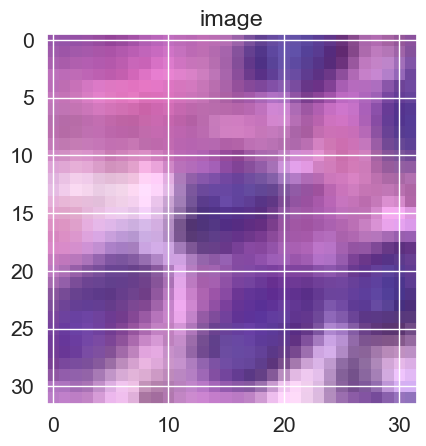

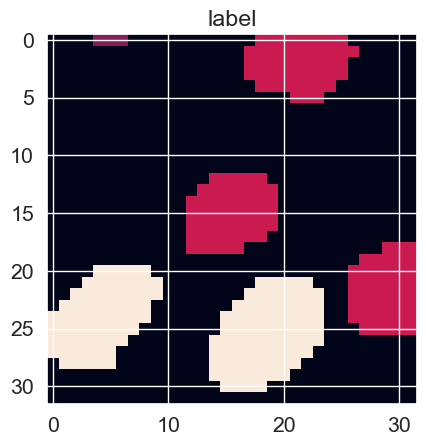

In [66]:
# classes = ['neutrophil', 'epithelial', 'lymphocyte', 'plasma', 'eosinophil', 'connective']
# classes
dataiter = iter(dataloader)
data = next(dataiter)
images, labels, classes = data
plt.imshow(images[0].permute(1, 2, 0))
plt.title("image")
plt.show()

# plt.imshow(old_images[0].permute(1, 2, 0))
# plt.title("old image")
# plt.show()

plt.imshow(labels[0])
plt.title("label")
plt.show()

# images[0]
# pred = net(images.float())
# pred[0]
# print(features.shape, labels.shape, pred.shape, pred.squeeze(1).shape)
# print(features.type(), labels.type(), pred.type(), pred.squeeze(1).type())
# loss_fn(pred.squeeze(1), classes)

In [67]:
num_epochs = 20
total_samples = len(train_data)
n_iterations = math.ceil(total_samples/32)
print(total_samples, n_iterations)
net = Net()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = FocalLoss(gamma=0.7)
m = torch.nn.Softmax(dim=-1)
# loss_fn = nn.NLLLoss()
# loss_fn = nn.KLDivLoss()
# opt = torch.optim.Adam(net.parameters(), lr=0.001)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

500000 15625


In [68]:
start_time = datetime.now()
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, labels, classes) in enumerate(dataloader):
        opt.zero_grad()
        outputs = net(inputs.float())
        loss = loss_fn(outputs, classes)
        loss.backward()
        opt.step()
        wandb.log({"loss_5": loss})
        # forward, backwards, update
        running_loss += loss.item()
        if (i+1) % 1000 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {running_loss / 1000}, time {(datetime.now()-start_time)}')
            running_loss = 0

epoch 1/20, step 1000/15625, loss 1.4054972170591353, time 0:00:16.125972
epoch 1/20, step 2000/15625, loss 1.294901750087738, time 0:00:32.612642
epoch 1/20, step 3000/15625, loss 1.2329961356520653, time 0:00:49.275512
epoch 1/20, step 4000/15625, loss 1.1938140510320663, time 0:01:05.938414
epoch 1/20, step 5000/15625, loss 1.1765998013615608, time 0:01:22.605682
epoch 1/20, step 6000/15625, loss 1.1413804820775986, time 0:01:39.267885
epoch 1/20, step 7000/15625, loss 1.1413160989284514, time 0:01:55.980445
epoch 1/20, step 8000/15625, loss 1.1302548995018005, time 0:02:12.524303
epoch 1/20, step 9000/15625, loss 1.1053696148395538, time 0:02:29.158170
epoch 1/20, step 10000/15625, loss 1.1070318645238877, time 0:02:45.831754
epoch 1/20, step 11000/15625, loss 1.1008168238401412, time 0:03:02.312270
epoch 1/20, step 12000/15625, loss 1.0741250905394555, time 0:03:18.908396
epoch 1/20, step 13000/15625, loss 1.075763641178608, time 0:03:35.444561
epoch 1/20, step 14000/15625, loss 1

In [70]:
torch.save(net, "net_g_cell_crop_7")

In [34]:
net = Net()
net = torch.load("net_g_cell_crop_3")

In [71]:
dataloader_test = DataLoader(dataset=test_data, batch_size=32, shuffle=True)
dataiter = iter(dataloader)

tensor([-13.3621,  -2.5606,   4.2915,   3.2284,   3.6296,  -3.2161,   3.7066])
pred 2
truth 6


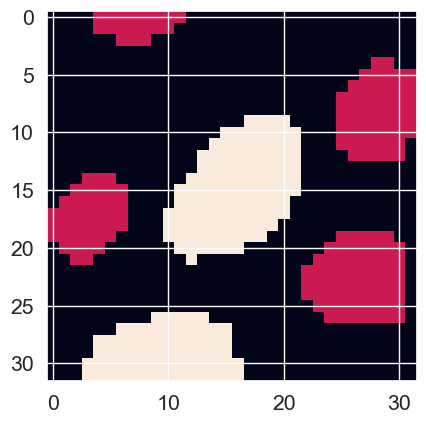

In [72]:
data = next(dataiter)
images, labels, classes = data
with torch.no_grad():
    outputs = net(images.float())
    print(outputs[0])
    print(f'pred {np.where(outputs[0] == outputs[0].max())[0][0]}')
    print(f'truth {classes[0].item()}')
    # print(f'truth {np.where(classes[0] == classes[0].max())[0][0]}')
    plt.imshow(labels[0].detach().numpy())
    plt.show()

In [73]:
total_samples = len(test_data)
n_iterations = math.ceil(total_samples/32)
correct = 0
total = 0
confusion_matrix = np.zeros((6, 6), dtype=np.uint8)
confusion_matrix_images = np.zeros((6, 6, 3, 32, 32), dtype=np.uint8)
total_predictions = np.zeros(6, dtype=np.uint8)
total_classes = np.zeros(6, dtype=np.uint8)
img_count = 0
with torch.no_grad():
    for i, (inputs, labels, classes) in enumerate(dataloader_test):
        outputs = net(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        total += classes.size(0)
        correct += (predicted == classes).sum().item()
        # [confusion_matrix[pr-1, cl-1] += 1 for i in zip(predicted, classes)]
        for j, (pr, cl) in enumerate(zip(predicted, classes)):
            confusion_matrix[pr.item()-1, cl.item()-1] += 1
            total_predictions[pr.item()-1] += 1
            total_classes[cl.item()-1] += 1
            if np.sum(confusion_matrix_images[pr.item()-1, cl.item()-1]) == 0:
                confusion_matrix_images[pr.item()-1, cl.item()-1] = inputs[j]
                
#                 im = Image.fromarray(inputs[j].detach().numpy().astype(np.uint8).transpose(1, 2, 0))
#                 im.save(f"vis/cropped-norm-{img_count}.png")
                
#                 im = Image.fromarray(old_images[j].detach().numpy().astype(np.uint8).transpose(1, 2, 0))
#                 im.save(f"vis/cropped-old-{img_count}.png")
                
                img_count += 1
        if (i+1) % 500 == 0:
            print(f'step {i+1} / {n_iterations}')

print(f'Accuracy of the network on {total} test images: {(correct / total) * 100:.2f} %')

step 500 / 4083
step 1000 / 4083
step 1500 / 4083
step 2000 / 4083
step 2500 / 4083
step 3000 / 4083
step 3500 / 4083
step 4000 / 4083
Accuracy of the network on 130652 test images: 69.33 %


In [74]:
fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
i = 1
for row in range(rows):
    for column in range(columns):
        img = confusion_matrix_images[row, column].transpose(1, 2, 0)
        # fig.add_subplot(rows, columns, i)
        # plt.imshow(img)
        i+=1
# plt.show()

<Figure size 800x800 with 0 Axes>

In [75]:
print("predictions count: ", total_predictions)
print("classes count:     ", total_classes)

predictions count:  [177  48 171 207 181  76]
classes count:      [ 23  71  18  71 247 174]


In [76]:
confusion_matrix
#   g r o u n d  t h r u t h
# p
# r
# e
# d
# i
# c
# t

array([[184, 215, 132,  74,   8,  76],
       [ 91,  10, 175,   9, 200,  75],
       [139,  52,   5, 226, 247,  14],
       [ 22,  76,  98,  81,  18, 168],
       [224, 150, 154, 115,  71, 235],
       [131,  80, 222,  78, 215, 118]], dtype=uint8)

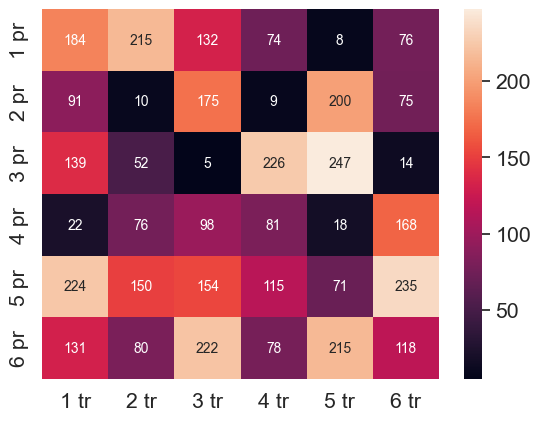

In [77]:
df = pd.DataFrame(confusion_matrix, [str(i) + " pr" for i in range(1,7)], [str(i) + " tr" for i in range(1,7)])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 10}, fmt='g') # font size

plt.show()

# RESULTS

## 2 layers, without augmentation, net_cell_crop_1

Accuracy of the network on 53921 test images: 68.08 %

classes: [18457, 3539, 150346, 56178, 16374, 2905, 106122]

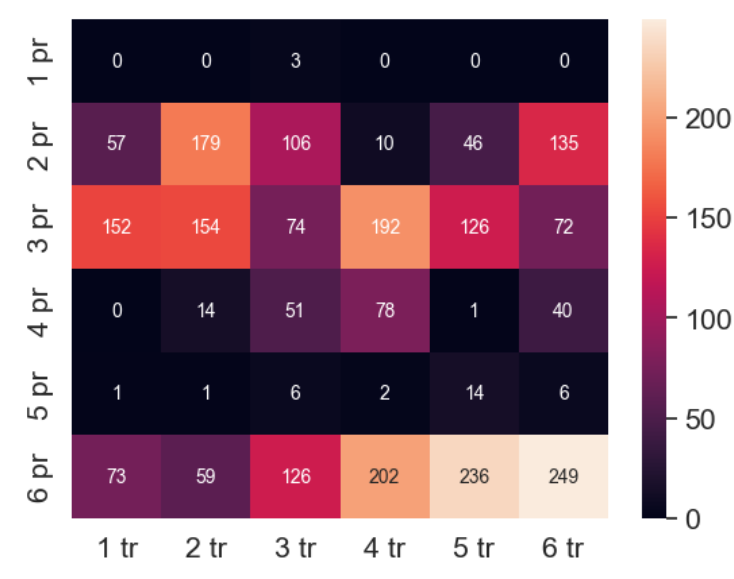

---

## 2 layers, with (7) augmentation on classes 1 and 5, net_cell_crop_2

Accuracy of the network on 59029 test images: 66.39 %

classes: [18457, 28312, 150346, 56178, 16374, 23240, 106122]

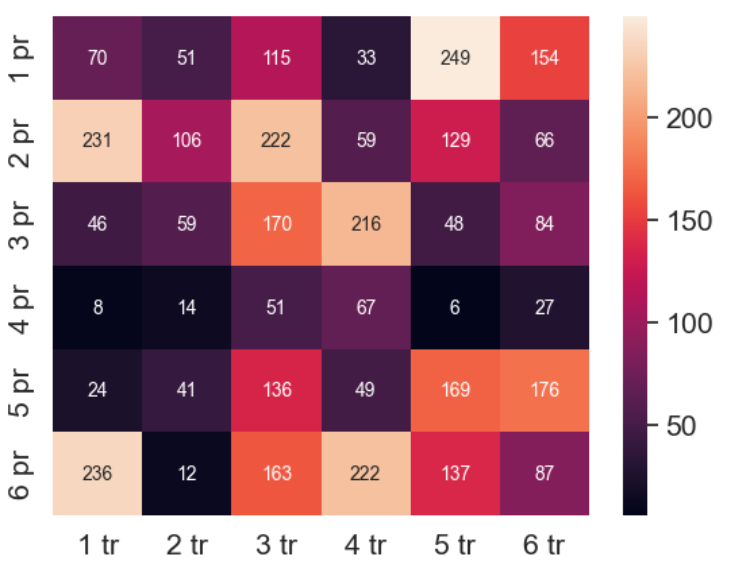

---

## 2 layers, with (7) augmentation on classes 1 and 5, better anotated dataset, net_g_cell_crop_1

Accuracy of the network on 130652 test images: 75.97 %

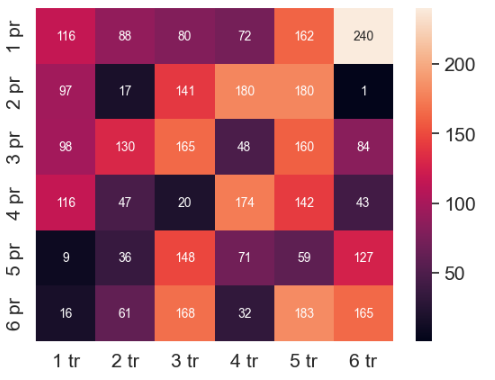

---

## 3 layers, with (7) augmentation on classes 1 and 5, better anotated dataset, net_g_cell_crop_2

Accuracy of the network on 130652 test images: 70.80 %

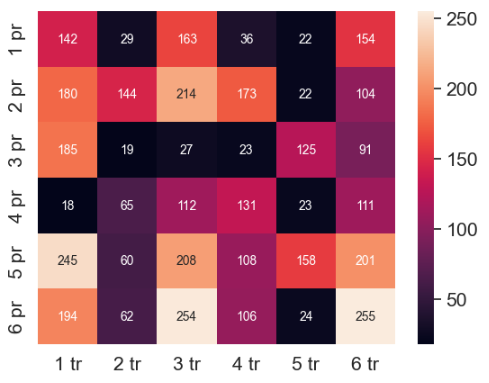

---

## 2 layers, with aug, size 64 -> BAD

Accuracy of the network on 130652 test images: 41.54 %

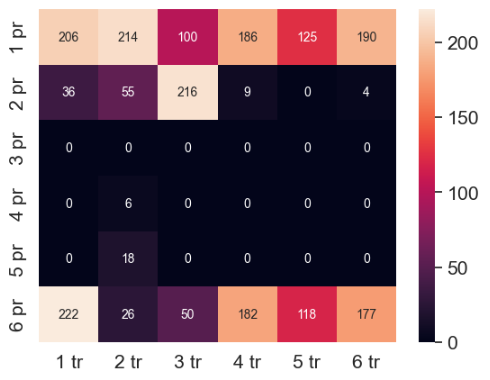

---

## 2 layers, with aug, with norm, net_g_cell_crop_3

Accuracy of the network on 130652 test images: 67.15 %

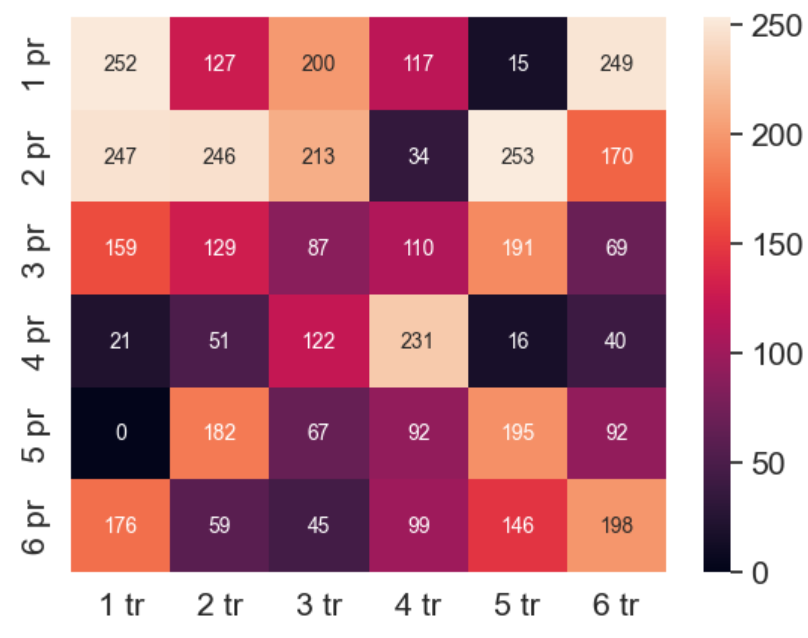

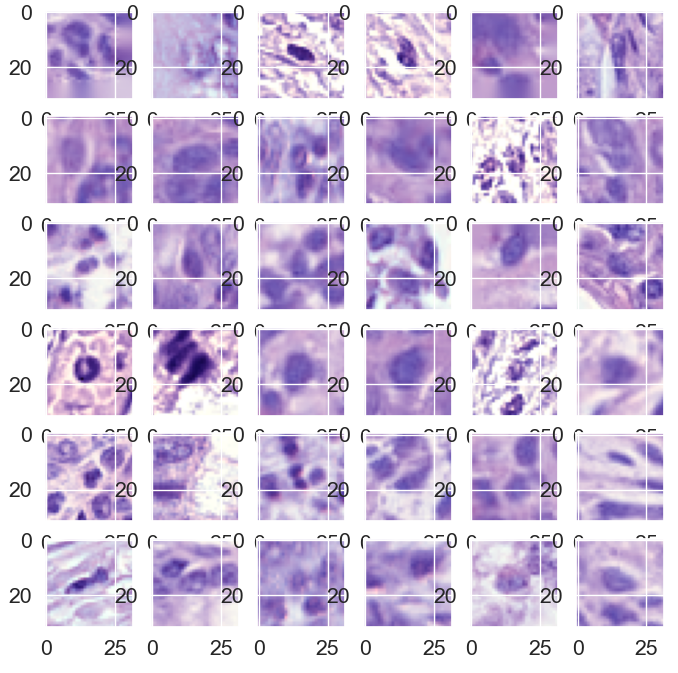

---

## 2 layers, 10 epochs, with aug, with norm, with cut outs, net_g_cell_crop_4

Accuracy of the network on 130652 test images: 64.59 %

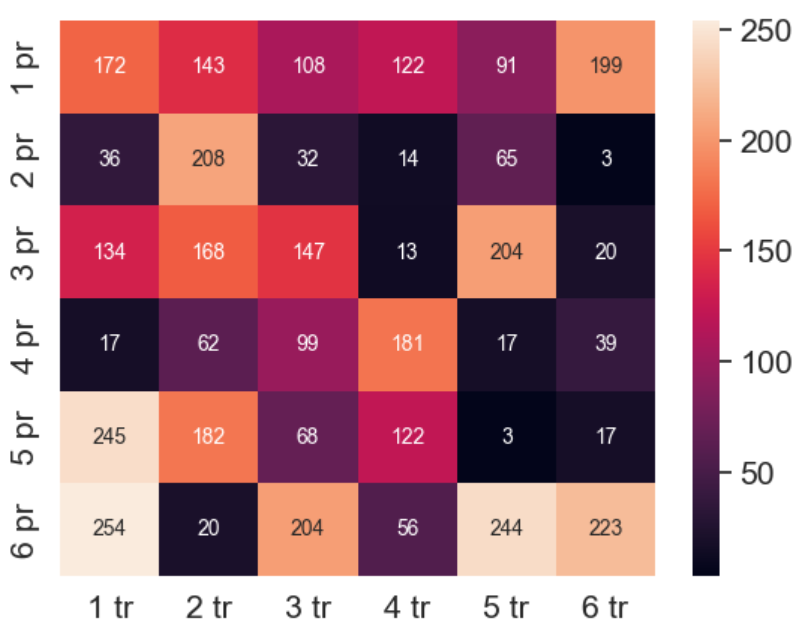
